<a href="https://colab.research.google.com/github/daeunni/Statistical_DL/blob/main/lec_code/9_%EB%B9%84%EC%88%9C%ED%99%98%ED%98%95_%EC%95%84%ED%82%A4%ED%85%8D%EC%B2%98(Inception).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **9. 비순환형(Acyclic) 아키텍처**

- CNN의 2d conv 필터로 공간적정보만 수집하는 것이 아니라, (1,1) 2d conv로 채널의 정보를 수집

> 공간정보와 채널정보를 동시에 이용하는 병렬형 CNN 아키텍처

- 모수의 개수가 그만큼 많아지므로 과대적합에 유의해야함

- **InceptionV3 이전학습**

In [ ]:
import pandas as pd 
from skimage import io   # 이미지 read
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense, Dropout
from tensorflow.keras.models import Sequential

data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/[STAT433] 딥러닝을 위한 통계적모델링/data/gender_data.csv')  
data.head(2)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42


In [ ]:
data_male=data[data['please_select_the_gender_of_the_person_in_the_picture']=='male']
data_female=data[data['please_select_the_gender_of_the_person_in_the_picture']=='female']

## 상위 2000개만 사용
final_data=pd.concat([data_male[:1000],data_female[:1000]], axis=0).reset_index(drop=True)

x=[]
y=[]
for i in range(final_data.shape[0]):
    try:
        image=io.imread(final_data.loc[i]['image_url'])
        if (image.shape==(300,300,3)):
            x.append(image)
            y.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture'])
    except:
        continue

In [ ]:
print(x[0])
print(y[0])

[[[92 86 74]
  [92 86 74]
  [92 86 74]
  ...
  [86 79 69]
  [86 79 69]
  [86 79 69]]

 [[90 84 72]
  [90 84 72]
  [91 85 73]
  ...
  [86 79 69]
  [86 79 69]
  [86 79 69]]

 [[87 81 69]
  [88 82 70]
  [90 84 72]
  ...
  [86 79 69]
  [85 78 68]
  [85 78 68]]

 ...

 [[14 14 12]
  [13 13 11]
  [12 12 10]
  ...
  [14 15 10]
  [14 15 10]
  [14 15 10]]

 [[14 14 12]
  [13 13 11]
  [12 12 10]
  ...
  [13 14  9]
  [13 14  9]
  [13 14  9]]

 [[14 14 12]
  [13 13 11]
  [12 12 10]
  ...
  [13 14  9]
  [13 14  9]
  [13 14  9]]]
male


In [ ]:
# x1=[]
# y1=[]
# for i in range(len(x)):
#     x1.append(x[i])
#     img_label=np.where(y[i]=='male',1,0)
#     y1.append(img_label)
    
# x1=np.array(x)
# x=np.array(x1)/255.
# y=np.array(y1)
# print(x.shape)
# print(y.shape)

(1730, 300, 300, 3)
(1730,)


In [ ]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications.inception_v3 import preprocess_input

incep_model=inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(300,300,3))
incep_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Inception output 출력 

In [ ]:
inception_output = []
for i in range(len(x)):
    img=x[i]
    img = preprocess_input(img.reshape(1,300,300,3))
    img_new = incep_model.predict(img.reshape(1,300,300,3))   # inception model 출력
    inception_output.append(img_new)   # inception output 넣음 

inception_output = np.array(inception_output )
print(inception_output .shape)
inception_output  = inception_output.reshape(inception_output.shape[0], inception_output.shape[2], inception_output.shape[3], inception_output.shape[4])

(3471, 1, 8, 8, 2048)


In [ ]:
# ont-hot encoding
y1 = []
for i in range(len(x)):
    img_label=np.where(y[i]=='male',1,0)
    y1.append(img_label)

y1 = np.array(y1)

In [ ]:
# split 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(inception_output, y1, test_size=0.15)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(2950, 8, 8, 2048)
(521, 8, 8, 2048)
(2950,)


## 이전학습
- InceptionV3의 Output을 다시 Conv2d 신경망에 넣는다

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
model_v3=Sequential()
model_v3.add(Conv2D(512,3,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))

model_v3.add(Flatten())
model_v3.add(Dense(200,activation='relu', kernel_initializer='he_normal'))
model_v3.add(Dropout(0.5))
model_v3.add(Dense(100,activation='relu'))
model_v3.add(Dense(1,activation='sigmoid'))
model_v3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 6, 6, 512)         9437696   
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               3686600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 13,144,497
Trainable params: 13,144,497
Non-trainable params: 0
__________________________________________

In [ ]:
model_v3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
history_v3=model_v3.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
74/74 [==============================] - 2s 21ms/step - loss: 1.8214 - acc: 0.7089 - val_loss: 0.2044 - val_acc: 0.9068
Epoch 2/20
74/74 [==============================] - 1s 17ms/step - loss: 0.2068 - acc: 0.9224 - val_loss: 0.2033 - val_acc: 0.9288
Epoch 3/20
74/74 [==============================] - 1s 17ms/step - loss: 0.1757 - acc: 0.9294 - val_loss: 0.2396 - val_acc: 0.9051
Epoch 4/20
74/74 [==============================] - 1s 17ms/step - loss: 0.2308 - acc: 0.9163 - val_loss: 0.3385 - val_acc: 0.8712
Epoch 5/20
74/74 [==============================] - 1s 17ms/step - loss: 0.1840 - acc: 0.9381 - val_loss: 0.2005 - val_acc: 0.9220
Epoch 6/20
74/74 [==============================] - 1s 17ms/step - loss: 0.1382 - acc: 0.9432 - val_loss: 0.3848 - val_acc: 0.8576
Epoch 7/20
74/74 [==============================] - 1s 17ms/step - loss: 0.1342 - acc: 0.9460 - val_loss: 0.2558 - val_acc: 0.9186
Epoch 8/20
74/74 [==============================] - 1s 17ms/step - loss: 0.0927 - a

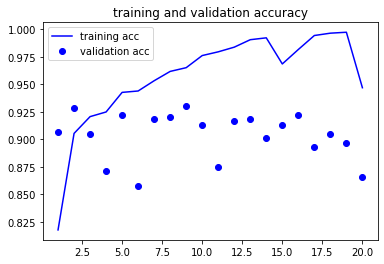

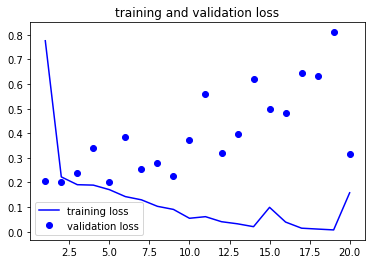

In [ ]:
import matplotlib.pyplot as plt
acc=history_v3.history['acc']
val_acc=history_v3.history['val_acc']
loss=history_v3.history['loss']
val_loss=history_v3.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

## 병렬형 CNN

In [ ]:
x1=[]
y1=[]
for i in range(len(x)):
    x1.append(x[i])
    img_label=np.where(y[i]=='male',1,0)
    y1.append(img_label)
    
x1=np.array(x)
x=np.array(x1)/255.
y=np.array(y1)
print(x.shape)
print(y.shape)

(1730, 300, 300, 3)
(1730,)


In [ ]:
# 다시 split 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.15)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(1470, 300, 300, 3)
(260, 300, 300, 3)
(1470,)


In [ ]:
from tensorflow.keras.layers import Conv2D, AveragePooling2D, concatenate,Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Input
image_input=Input(shape=(300,300,3))
branch_a=Conv2D(64,1,activation='relu',strides=2)(image_input)

branch_b=Conv2D(64,1,activation='relu')(image_input)
branch_b=Conv2D(64,3, activation='relu',padding='same',strides=2)(branch_b)

branch_c=AveragePooling2D(2)(image_input)   # average pooling을 취함
branch_c=Conv2D(64,3,activation='relu',padding='same')(branch_c)

branch_d=Conv2D(64,5,activation='relu',padding='same')(image_input)
branch_d=Conv2D(64,3,activation='relu',padding='same')(branch_d)
branch_d=Conv2D(64,3,activation='relu',padding='same',strides=2)(branch_d)

concatenated=concatenate([branch_a,branch_b,branch_c],axis=-1)
out1=Flatten()(concatenated)
out=Dense(1, activation='sigmoid')(out1)

model=Model(image_input,out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 300, 300, 64) 256         input_2[0][0]                    
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 150, 150, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 150, 150, 64) 256         input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
history=model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
46/46 [==============================] - 7s 140ms/step - loss: 29.4210 - acc: 0.5418 - val_loss: 1.6548 - val_acc: 0.6231
Epoch 2/10
46/46 [==============================] - 6s 135ms/step - loss: 1.6102 - acc: 0.6362 - val_loss: 2.2974 - val_acc: 0.5538
Epoch 3/10
46/46 [==============================] - 6s 135ms/step - loss: 1.0873 - acc: 0.6856 - val_loss: 0.8630 - val_acc: 0.6500
Epoch 4/10
46/46 [==============================] - 6s 135ms/step - loss: 0.5036 - acc: 0.7937 - val_loss: 0.6552 - val_acc: 0.7077
Epoch 5/10
46/46 [==============================] - 6s 135ms/step - loss: 0.2801 - acc: 0.8801 - val_loss: 0.7378 - val_acc: 0.6923
Epoch 6/10
46/46 [==============================] - 6s 135ms/step - loss: 0.2526 - acc: 0.8982 - val_loss: 0.6400 - val_acc: 0.7000
Epoch 7/10
46/46 [==============================] - 6s 135ms/step - loss: 0.1560 - acc: 0.9433 - val_loss: 0.8037 - val_acc: 0.6923
Epoch 8/10
46/46 [==============================] - 6s 135ms/step - loss: 0

In [ ]:
score = model.evaluate(x_test, y_test)
print(score)

9/9 [==============================] - 0s 43ms/step - loss: 0.7928 - acc: 0.7154
[0.7927679419517517, 0.7153846025466919]


- 인셉션 모듈은 저층에서 학습이 떨어진다고 알려져있음. 따라서 일반적인 Inception 모듈도 앞에서는 pre-layer라고 해서 일반적인 CNN연산을 거친다. 

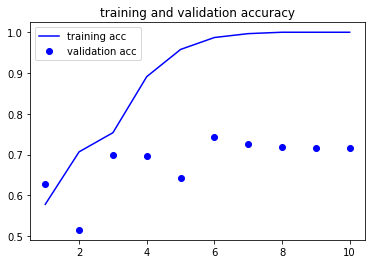

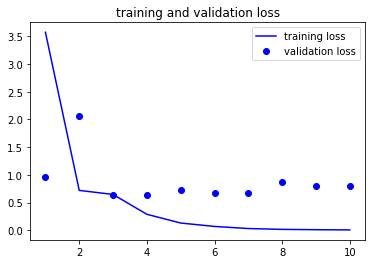

In [ ]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
history=model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
46/46 [==============================] - 7s 140ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/10
46/46 [==============================] - 6s 138ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/10
46/46 [==============================] - 6s 135ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/10
46/46 [==============================] - 6s 139ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.0000e+00 - acc: 1.0000